## Imports

Here we import the required libraries

In [1]:
#%pip install --upgrade pip
#%pip install torchsummary albumentations wandb --quiet
#%pip install tqdm 
#%pip install pandas 
#%pip install torch
#%pip install PIL
#%pip install torchvision
#%pip install matplotlib
#%pip install scikit-learn
#%pip install scikit-image
#%pip install setuptools
#%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#%pip install optuna
#%pip install -U albumentations

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from __future__ import print_function, division

from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
tqdm_notebook.pandas()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy.typing import NDArray
from functools import reduce
from itertools import islice
import wandb
import math
from itertools import chain
import copy
from PIL import Image

import torch
from torch import nn
from torch import Tensor
from torch.optim import Optimizer
import torch.nn.functional as F
import torchvision 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary
# Import albumentations library in order to -use pre-built augmentations
import albumentations as A

from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count

import os
import torch
import os.path as osp
from skimage import io, transform
import matplotlib.pyplot as plt
import typing as ty
import cv2
import optuna

In [3]:
torch.manual_seed(32)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')
test = torch.ones((100, 100)).to(device)
del test
torch.cuda.empty_cache()

Using cuda


## Dataset

This is done in order to control randomness.

In [4]:
DATA_DIR = './Datos/' #'/kaggle/input/fa-ii-2025-i-object-localization/'
WORK_DIR = './Datos/' #'/kaggle/working'
DIR_Results = './Resultados/'
os.makedirs(DIR_Results, exist_ok=True)
BATCH_SIZE = 32

img_dir = osp.join(DATA_DIR, "images/images")

df = pd.read_csv(osp.join(DATA_DIR, "train.csv"))

obj2id  = {'f16':0,'cougar':1,'chinook':2,'ah64':3,'f15':4,'seahawk':5}

id2obj  = {0:'f16',1:'cougar',2:'chinook',3:'ah64',4:'f15',5:'seahawk'}

df["class_id"] = df["class"].map(obj2id)

columns_f=['filename','xmin','ymin','xmax','ymax','class','class_id']

df= df[columns_f].copy()

## EDA

In [5]:
img_filename = osp.join(DATA_DIR, "images/images",'image_00077.jpeg')

img1 = cv2.imread(img_filename)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = io.imread(img_filename) # no necesita bgr2rgb

In [6]:
print(img1.shape)
print(img1.transpose((2,0,1)).shape)

(720, 1280, 3)
(3, 720, 1280)


In [7]:
list_image = list(df.filename)
data_shape = []
data_dim = []
data_w = []
data_h = []

for i in tqdm(list_image): ## tqdm(list_image)dura 40 segundos
    ruta_imagen = osp.join(img_dir, i)
    imagen = io.imread(ruta_imagen)
    shapes = imagen.shape
    dimen = imagen.ndim
    imagen = Image.open(ruta_imagen)
    w, h = imagen.size
    data_w.append(w)
    data_h.append(h)
    data_shape.append(shapes)
    data_dim.append(dimen)

data_w_h = pd.DataFrame([list_image,data_shape,data_dim,data_w,data_h]).T.rename(columns={0:'filename',1:'shapes',2:'ndim',3:'w',4:'h'}) 

100%|██████████| 189/189 [00:00<00:00, 227.42it/s]


In [8]:
data_w_h['w'].value_counts()

w
1280    189
Name: count, dtype: int64

In [9]:
data_w_h['ndim'].value_counts()


ndim
3    189
Name: count, dtype: int64

In [10]:
data_w_h['shapes'].value_counts()

shapes
(720, 1280, 3)    189
Name: count, dtype: int64

In [11]:
df['class_id'].value_counts()

class_id
0    41
1    37
2    35
3    34
4    23
5    19
Name: count, dtype: int64

In [12]:
df['class'].value_counts()

class
f16        41
cougar     37
chinook    35
ah64       34
f15        23
seahawk    19
Name: count, dtype: int64

In [13]:
df[df['xmin']>=df['xmax']].shape, df[df['ymin']>=df['ymax']].shape

((0, 7), (0, 7))

In [14]:
h_real=720
w_real=1280
h, w, c = 255, 400, 3 # The heigh, width and number of channels of each image

## Normalizamos los bboxes (En la siguiente monitoria hablaremos de la importancia)

In [15]:
print(df[["ymin", "ymax", "xmin", "xmax"]].describe())

             ymin        ymax        xmin         xmax
count  189.000000  189.000000  189.000000   189.000000
mean   186.396825  425.455026  401.238095   902.666667
std    112.079883  103.348946  232.361996   213.588688
min      1.000000  154.000000    1.000000   298.000000
25%    109.000000  359.000000  210.000000   730.000000
50%    188.000000  417.000000  418.000000   901.000000
75%    267.000000  494.000000  572.000000  1071.000000
max    440.000000  702.000000  944.000000  1280.000000


In [16]:
# Normalizar las columnas ymin, ymax, xmin, xmax
df[["ymin", "ymax"]] = df[["ymin", "ymax"]].div(h_real, axis=0)
df[["xmin", "xmax"]] = df[["xmin", "xmax"]].div(w_real, axis=0)


In [17]:
print(df[["ymin", "ymax", "xmin", "xmax"]].describe())

             ymin        ymax        xmin        xmax
count  189.000000  189.000000  189.000000  189.000000
mean     0.258884    0.590910    0.313467    0.705208
std      0.155667    0.143540    0.181533    0.166866
min      0.001389    0.213889    0.000781    0.232813
25%      0.151389    0.498611    0.164062    0.570312
50%      0.261111    0.579167    0.326562    0.703906
75%      0.370833    0.686111    0.446875    0.836719
max      0.611111    0.975000    0.737500    1.000000


## Particionamiento

In [18]:
train_df, val_df = train_test_split(
    #df, stratify=df['class_id'], test_size=0.25, random_state=42
    df, stratify=df['class_id'], test_size=0.25, random_state=42
)

print(train_df.shape)
print(val_df.shape)


(141, 7)
(48, 7)


In [19]:
train_df['class'].value_counts(1) * 100

class
f16        21.985816
cougar     19.858156
chinook    18.439716
ah64       17.730496
f15        12.056738
seahawk     9.929078
Name: proportion, dtype: float64

In [20]:
val_df['class_id'].value_counts(1) * 100

class_id
0    20.833333
2    18.750000
1    18.750000
3    18.750000
4    12.500000
5    10.416667
Name: proportion, dtype: float64

## Clase para estructura de los datos

In [21]:
transform_func_inp_signature = ty.Dict[str, NDArray[np.float64]]
transform_func_signature = ty.Callable[
    [transform_func_inp_signature],
    transform_func_inp_signature
]

class militarDataset(Dataset):
    """
    Location image dataset
    """
    def __init__(
        self, 
        df: pd.DataFrame, 
        root_dir: str, 
        labeled: bool = True,
        transform: ty.Optional[ty.List[transform_func_signature]] = None,
        output_size: ty.Optional[tuple] = None  # Añadir parámetro para tamaño de salida
    ) -> None:
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.labeled = labeled
        self.output_size = output_size  # Almacenar el tamaño de salida
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx: int) -> transform_func_signature: 
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Read image
        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])
        #img_name = os.path.join(self.root_dir, self.df.iloc[idx]['filename'])
        image = io.imread(img_name)
        #image = cv2.imread(img_name)
        
        
        #print(f"Dimensiones originales de la imagen: {image.shape}")  # Agregar para depuración
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_name}")
            
        if image.ndim == 2:  # Si la imagen está en escala de grises
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convertir a RGB
        elif image.shape[2] == 4:  # Si la imagen es RGBA
            image = image[:, :, :3] 
            
        # Redimensionar la imagen si se especifica un tamaño de salida
        if self.output_size:
            image = cv2.resize(image, self.output_size)  # Redimensionar la imagen
        
        sample = {'image': image}
        
        if self.labeled:
            # Read labels
            img_class = self.df.class_id.iloc[idx]
            img_bbox = self.df.iloc[idx, 1:5]

            img_bbox = np.array([img_bbox]).astype('float')
            img_class = np.array([img_class]).astype('int')
            sample.update({'bbox': img_bbox, 'class_id': img_class})
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

## Funciones para dibujar

In [22]:
def draw_bbox(img, bbox, color,thickness: int = 3):
    xmin, ymin, xmax, ymax = bbox
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, thickness)
    return img

def normalize_bbox(bbox, h: int, w: int):
    """Escala las coordenadas normalizadas al tamaño real de la imagen."""
    return [
        int(bbox[0] * w),  # xmin
        int(bbox[1] * h),  # ymin
        int(bbox[2] * w),  # xmax
        int(bbox[3] * h),  # ymax
    ]

def draw_bboxes(imgs, bboxes, colors,thickness):
    """Dibuja múltiples cuadros delimitadores en imágenes, escalando según h y w."""
    for i, (img, bbox, color) in enumerate(zip(imgs, bboxes, colors)):
        imgs[i] = draw_bbox(img, bbox, color,thickness)
    return imgs

def draw_classes(imgs, classes, colors, origin, prefix: str ='',fontScale : int = 2):
    """Dibuja las clases en las imágenes."""
    for i, (img, class_id, color) in enumerate(zip(imgs, classes, colors)):
        if type(c)==list:
            name_class_=id2obj[classes[i]]
        else:
            name_class_=id2obj[classes[i][0]]
        imgs[i] = cv2.putText(
            img, f'{prefix}{name_class_}', #class_id.squeeze()
            origin, cv2.FONT_HERSHEY_SIMPLEX,
            fontScale , color, 2, cv2.LINE_AA
        )
    return imgs

def draw_predictions(imgs, classes, bboxes, colors, origin,thickness,fontScale):
    """
    Combina las funciones anteriores para dibujar cuadros delimitadores
    y clases en las imágenes.
    """
    assert all(len(x) > 0 for x in [imgs, classes, bboxes, colors])
    if len(colors) == 1:
        colors = [colors[0] for _ in imgs]
    imgs = draw_bboxes(imgs, bboxes, colors,thickness)
    imgs = draw_classes(imgs, classes, colors, origin,"",fontScale)
    return imgs

## Graficamos una muestra de imagenes

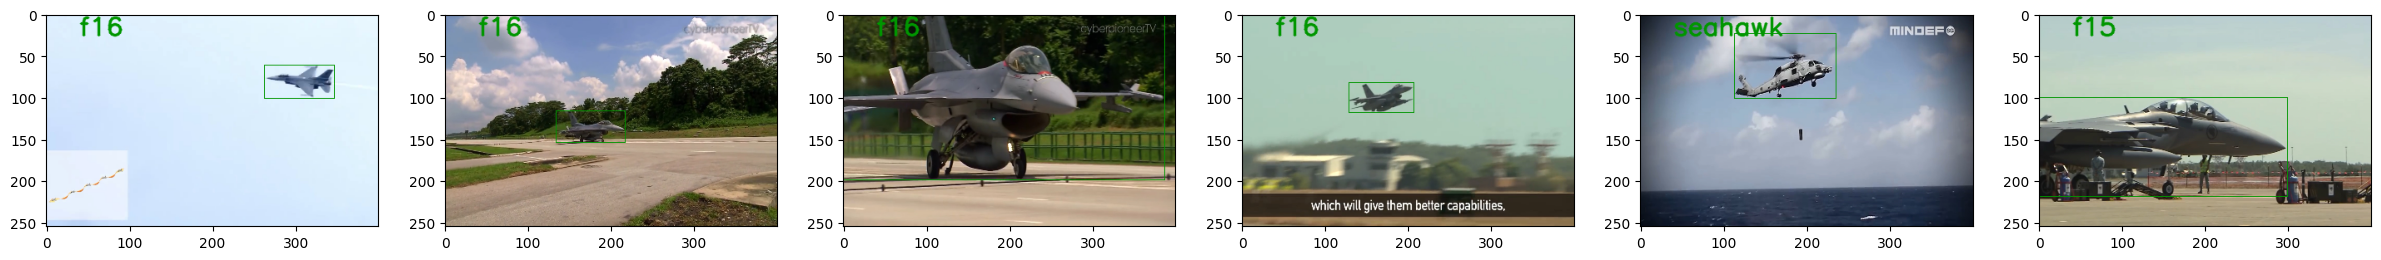

In [23]:
train_root_dir = osp.join(DATA_DIR, "images/images")#, "train"
train_ds = militarDataset(train_df, root_dir=train_root_dir,output_size=(w,h))

num_imgs = 6
start_idx = 0

samples = [train_ds[i] for i in range(start_idx, num_imgs)]

imgs = [s['image'] for s in samples]
bboxes = [normalize_bbox(s['bbox'].squeeze(),h,w) for s in samples]
classes = [s['class_id'] for s in samples]

imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (int(w*0.1), int(h*0.1)),thickness = 1,fontScale=1)#(150, 10)

fig = plt.figure(figsize=(30, num_imgs))

for i, img in enumerate(imgs):
    fig.add_subplot(1, num_imgs, i+1)
    plt.imshow(img)

plt.show()

## Normalización (Ahora de los píxeles, es diferente a la normalización anterior)

In [24]:
train_ds = militarDataset(train_df, root_dir=train_root_dir,output_size=(w,h))#,output_size=(255,255)

means = np.zeros(3)
stds = np.zeros(3)
n_images = 0

for x in train_ds:
    img = x['image']#.astype(np.float32)  # Asegúrate de que la imagen está en float para cálculos precisos
    n_images += 1

    for channel in range(3):
        channel_pixels = img[..., channel]
        # Acumular la suma y suma de cuadrados para calcular la media y desviación estándar
        means[channel] += np.mean(channel_pixels)
        stds[channel] += np.std(channel_pixels)

# Calcular la media y desviación estándar final
means /= n_images
stds /= n_images

In [25]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C (0,1,2)
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).float()
        sample.update({'image': image})
        return sample


class Normalizer(object):
    
    def __init__(self, stds, means):
        """
        Arguments:
        
            stds: array of length 3 containing the standard deviation of each channel in RGB order.
            means: array of length 3 containing the means of each channel in RGB order.
        """
        self.stds = stds
        self.means = means
    
    def __call__(self, sample):
        """
        Sample: a dicitonary containing:
            image: sample image in format (C, H, W)
        Returns:
            the image in (C, H, W) format with the channels normalized.
        """
        image = sample['image']
        
        for channel in range(3):
            image[channel] = (image[channel] - means[channel]) / stds[channel]

        sample['image'] = image
        return sample

class TVTransformWrapper(object):
    """Torch Vision Transform Wrapper
    """
    def __init__(self, transform: torch.nn.Module):
        self.transform = transform
        
    def __call__(self, sample):
        sample['image'] = self.transform(sample['image'])
        return sample

class AlbumentationsWrapper(object):
    
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, sample):
        transformed = self.transform(
            image=sample['image'], 
            bboxes=sample['bbox'],
            #category_ids=sample['class_id']
        )
        sample['image'] = transformed['image']
        sample['bbox'] = np.array(transformed['bboxes'])
        return sample

## Transformaciones

In [26]:
common_transforms = [
    ToTensor(),
    Normalizer(
        means=means,
        stds=stds,
    )
]

train_data_augmentations = A.Compose([
    A.HorizontalFlip(p=1),
    ],
    bbox_params=A.BboxParams(
        format='albumentations', 
        label_fields=[],
    )
)

train_transforms = torchvision.transforms.Compose(
    [
        AlbumentationsWrapper(train_data_augmentations),
    ] + common_transforms
)

eval_transforms = torchvision.transforms.Compose(common_transforms)

In [27]:
train_ds = militarDataset(df, root_dir=train_root_dir, transform=train_transforms,output_size=(w,h))#
train_data = torch.utils.data.DataLoader(train_ds, batch_size=16)#,collate_fn=custom_collate_fn

for x in train_data:
    print(x['image'].size())
    break

torch.Size([16, 3, 255, 400])


## Transfer Learning

In [28]:
from torchvision.models import densenet201, DenseNet201_Weights

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = model.features
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = self.flatten(x)
        x = self.dropout(x)
        return x

densenet_model = densenet201(weights=DenseNet201_Weights.DEFAULT)
pretrained_model = FeatureExtractor(densenet_model).to(device)


## Arquitectura

In [29]:
def get_output_shape(model: nn.Sequential, image_dim: ty.Tuple[int, int, int]):
    return model(torch.rand(*(image_dim)).to(device)).data.shape

class Model(nn.Module):
    def __init__(self, input_shape: ty.Tuple[int, int, int] = (3, 255, 400), n_classes: int = 6):
        """
        Model with one input (image) and two outputs: 
            1. Digit classification (classification).
            2. Bounding box prediction (regression). 
        
        Arguments:
            input_shape: input shape of the image in format (C, H, W)
            n_classes: number of classes to perfrom classification with
            
        Attributes:
            backbone: ConvNet that process the image and 
            returns a flattened vector with the information of the 
            activations.
            
            cls_head: MLP that receives the flattened input from the backbone 
            and predicts the classification logits for the classes (classficiation task).
            
            reg_head: MLP that receives the flattened input from the backbone 
            and predicts the coordinates of the predicted bounding box (regression task). 
        """
        super().__init__()
        
        self.input_shape = input_shape
        
        # When doing transfer learning, use pretrained model instead of custom backbone
        self.backbone = pretrained_model
        
        backbone_output_shape = get_output_shape(self.backbone, [1, *input_shape])
        backbone_output_features = reduce(lambda x, y: x*y, backbone_output_shape)
        
        self.cls_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=256),
            nn.ReLU(),            
            nn.Linear(256, n_classes)
        )
        
        self.reg_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x: Tensor) -> ty.Dict[str, Tensor]:
        features = self.backbone(x)
        cls_logits = self.cls_head(features)
        pred_bbox = self.reg_head(features)
        predictions = {'bbox': pred_bbox, 'class_id': cls_logits}
        return predictions

## Metricas

In [30]:
def iou(y_true: Tensor, y_pred: Tensor):
    # Ensure y_true and y_pred are 2D tensors of shape [N, 4]
    y_true = y_true.squeeze()
    y_pred = y_pred.squeeze()
    if y_true.ndim == 1:
        y_true = y_true.unsqueeze(0)
    if y_pred.ndim == 1:
        y_pred = y_pred.unsqueeze(0)
    pairwise_iou = torchvision.ops.box_iou(y_true, y_pred)
    result = torch.trace(pairwise_iou) / pairwise_iou.size(0)
    return result

In [31]:
def accuracy(y_true: Tensor, y_pred: Tensor):
    pred = torch.argmax(y_pred, axis=-1)
    y_true = y_true.squeeze()
    correct = torch.eq(pred, y_true).float()
    total = torch.ones_like(correct)
    result = torch.divide(torch.sum(correct), torch.sum(total))
    return result

## Loss fn

In [32]:
def loss_fn(y_true, y_preds, alpha: float = 0.5):
    cls_y_true, cls_y_pred = y_true['class_id'].long(), y_preds['class_id'].float().unsqueeze(-1)
    reg_y_true, reg_y_pred = y_true['bbox'].float().squeeze(), y_preds['bbox'].float().squeeze()
    
    cls_loss = F.cross_entropy(cls_y_pred, cls_y_true)
    
    reg_loss = F.mse_loss(reg_y_pred, reg_y_true)
    # Adds weights to both tasks
    total_loss = (1 - alpha) * cls_loss + alpha * reg_loss
    return dict(loss=total_loss, reg_loss=reg_loss,cls_loss=cls_loss)

# Adaptación para transfer y optuna

## 1. Configuración inicial e imports adicionales

In [ ]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import warnings
warnings.filterwarnings('ignore')

# Configuración global para Optuna
N_TRIALS = 50  # Número de pruebas a realizar
TIMEOUT = 7200  # Tiempo límite en segundos (2 horas)
STUDY_NAME = "military_detection_optimization"

# Configuración de entrenamiento para Optuna
TRAIN_STEPS_OPTUNA = 100  # Menos steps para optimización rápida
EVAL_STEPS_OPTUNA = 20
PATIENCE = 5  # Para early stopping

print("✅ Configuración de Optuna cargada")
print(f"Número de trials: {N_TRIALS}")
print(f"Timeout: {TIMEOUT/3600:.1f} horas")

✅ Configuración de Optuna cargada
Número de trials: 50
Timeout: 2.0 horas


## 2. Modelo configurable con dropout

In [ ]:

class ConfigurableFeatureExtractor(nn.Module):
    """
    Extractor de características configurable que añade dropout personalizable
    a un modelo preentrenado para reducir overfitting
    """
    def __init__(self, model, dropout_rate=0.5):
        super(ConfigurableFeatureExtractor, self).__init__()
        # Extrae solo la parte convolucional del modelo preentrenado (sin clasificador)
        self.features = model.features
        
        # Pooling adaptativo que reduce cualquier tamaño de feature map a 1x1
        # Esto hace el modelo flexible a diferentes tamaños de entrada
        self.pooling = nn.AdaptiveAvgPool2d(1)
        
        # Aplana las características para conectar con capas lineales
        self.flatten = nn.Flatten()
        
        # Dropout configurable para regularización y prevención de overfitting
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Pipeline de extracción de características
        x = self.features(x)      # Extracción de características convolucionales
        x = self.pooling(x)       # Reducción a vector de características global
        x = self.flatten(x)       # Conversión a tensor 1D
        x = self.dropout(x)       # Aplicación de regularización
        return x

class OptimizableModel(nn.Module):
    """
    Modelo multi-tarea optimizable que realiza:
    1. Clasificación (predice clase del objeto)
    2. Regresión (predice bounding box coordenadas)
    
    Utiliza DenseNet201 como backbone preentrenado para transfer learning
    """
    def __init__(self, input_shape: tuple = (3, 255, 400), n_classes: int = 6, dropout_rate: float = 0.5):
        super().__init__()
        
        self.input_shape = input_shape
        
        # BACKBONE: Usar DenseNet201 preentrenado como extractor de características
        # Transfer learning aprovecha características aprendidas en ImageNet
        densenet_model = densenet201(weights=DenseNet201_Weights.DEFAULT)
        self.backbone = ConfigurableFeatureExtractor(densenet_model, dropout_rate).to(device)
        
        # Calcular dinámicamente el tamaño de salida del backbone
        # Esto permite flexibilidad en el tamaño de entrada
        backbone_output_shape = get_output_shape(self.backbone, [1, *input_shape])
        backbone_output_features = reduce(lambda x, y: x*y, backbone_output_shape)
        
        # CABEZAL DE CLASIFICACIÓN
        # Red neuronal que predice la clase del objeto detectado
        self.cls_head = nn.Sequential(
            # Capa densa principal con 256 neuronas
            nn.Linear(in_features=backbone_output_features, out_features=256),
            nn.ReLU(),  # Función de activación no lineal
            
            # Dropout reducido (50% del rate principal) para capa intermedia
            # Menor regularización en capas internas para mantener capacidad de representación
            nn.Dropout(dropout_rate * 0.5),
            
            # Capa de salida con número de clases objetivo
            nn.Linear(256, n_classes)
        )
        
        # CABEZAL DE REGRESIÓN  
        # Red neuronal que predice coordenadas del bounding box (x, y, width, height)
        self.reg_head = nn.Sequential(
            # Capa más pequeña (128) ya que regresión es generalmente más simple
            nn.Linear(in_features=backbone_output_features, out_features=128),
            nn.ReLU(),
            
            # Mismo esquema de dropout reducido
            nn.Dropout(dropout_rate * 0.5),
            
            # Salida de 4 valores: coordenadas del bounding box
            nn.Linear(128, 4)
        )

    def forward(self, x: Tensor) -> dict:
        """
        Forward pass que genera predicciones tanto de clasificación como de regresión
        
        Returns:
            dict: Diccionario con 'bbox' (coordenadas) y 'class_id' (logits de clase)
        """
        # Extraer características compartidas del backbone
        features = self.backbone(x)
        
        # Generar predicciones independientes para cada tarea
        cls_logits = self.cls_head(features)    # Logits para clasificación
        pred_bbox = self.reg_head(features)     # Coordenadas del bounding box
        
        # Retornar predicciones en formato de diccionario para fácil acceso
        predictions = {'bbox': pred_bbox, 'class_id': cls_logits}
        return predictions

def create_optimizer(optimizer_name: str, model_params, learning_rate: float):
    """
    Factory function para crear diferentes tipos de optimizadores con configuraciones óptimas
    
    Args:
        optimizer_name: Nombre del optimizador ('adam', 'adamw', 'sgd')
        model_params: Parámetros del modelo a optimizar
        learning_rate: Tasa de aprendizaje base
        
    Returns:
        torch.optim.Optimizer: Optimizador configurado
    """
    # Diccionario de optimizadores disponibles
    optimizers = {
        'adam': torch.optim.Adam,      # Adam estándar
        'adamw': torch.optim.AdamW,    # Adam con weight decay mejorado
        'sgd': torch.optim.SGD         # Stochastic Gradient Descent clásico
    }
    
    # Validación de entrada
    if optimizer_name not in optimizers:
        raise ValueError(f"Optimizador {optimizer_name} no soportado")
    
    # Configuraciones específicas optimizadas para cada optimizador
    if optimizer_name == 'sgd':
        # SGD requiere momentum y weight decay para convergencia estable
        return optimizers[optimizer_name](
            model_params, 
            lr=learning_rate, 
            momentum=0.9,        # Ayuda a superar mínimos locales
            weight_decay=1e-4    # Regularización L2 moderada
        )
    elif optimizer_name == 'adamw':
        # AdamW con weight decay desacoplado (mejor que Adam estándar)
        return optimizers[optimizer_name](
            model_params, 
            lr=learning_rate, 
            weight_decay=1e-2    # Weight decay más agresivo que SGD
        )
    else:  # adam
        # Adam estándar sin configuraciones adicionales
        return optimizers[optimizer_name](model_params, lr=learning_rate)

print("✅ Modelo configurable y factory de optimizadores creados")

✅ Modelo configurable y factory de optimizadores creados


## 3. Función de entrenamiento para optuna

In [ ]:

def train_for_optuna(
    model: OptimizableModel, 
    optimizer: Optimizer, 
    train_loader: DataLoader,
    val_loader: DataLoader,
    loss_fn: callable,
    device: str,
    train_steps: int = 200,
    eval_steps: int = 20,
    patience: int = 3,
    trial=None  # Para reportar valores intermedios a Optuna
) -> float:
    """
    Función de entrenamiento optimizada para Optuna con early stopping
    
    Returns:
        float: Mejor IoU de validación obtenido
    """
    model = model.to(device)
    best_val_iou = 0.0
    patience_counter = 0
    iters = 0
    
    # Iteradores
    train_iterator = iter(train_loader)
    
    # Métricas para seguimiento
    train_losses = []
    val_ious = []
    
    while iters <= train_steps:
        # =================
        # FASE DE ENTRENAMIENTO
        # =================
        model.train()
        
        try:
            batch = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)
        
        # Forward pass
        optimizer.zero_grad()
        img = batch.pop('image').to(device)
        
        for k in list(batch.keys()):
            batch[k] = batch[k].to(device)
        
        preds = model(img.float())
        losses = loss_fn(batch, preds)
        final_loss = losses['loss']
        
        # Backward pass
        final_loss.backward()
        optimizer.step()
        
        train_losses.append(final_loss.item())
        
        # =================
        # FASE DE EVALUACIÓN
        # =================
        if iters % eval_steps == 0:
            model.eval()
            val_iou_batch = []
            val_loss_batch = []
            
            with torch.no_grad():
                for val_batch in val_loader:
                    val_img = val_batch.pop('image').to(device)
                    
                    for k in list(val_batch.keys()):
                        val_batch[k] = val_batch[k].to(device)
                    
                    val_preds = model(val_img.float())
                    val_losses = loss_fn(val_batch, val_preds)
                    
                    # Calcular IoU
                    batch_iou = iou(val_batch['bbox'], val_preds['bbox'])
                    val_iou_batch.append(batch_iou.item())
                    val_loss_batch.append(val_losses['loss'].item())
            
            # Métricas promedio de validación
            current_val_iou = np.mean(val_iou_batch)
            current_val_loss = np.mean(val_loss_batch)
            val_ious.append(current_val_iou)
            
            # Imprimir progreso cada 10 evaluaciones
            if (iters // eval_steps) % 10 == 0:
                print(f"Iter {iters:4d} | Train Loss: {np.mean(train_losses[-10:]):.4f} | "
                      f"Val IoU: {current_val_iou:.4f} | Val Loss: {current_val_loss:.4f}")
            
            # Reportar valor intermedio a Optuna
            if trial is not None:
                trial.report(current_val_iou, iters)
                
                # Verificar si el trial debe ser podado
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
            
            # Early stopping logic
            if current_val_iou > best_val_iou:
                best_val_iou = current_val_iou
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"Early stopping en iteración {iters} (paciencia agotada)")
                break
        
        iters += 1
    
    print(f"Entrenamiento completado. Mejor Val IoU: {best_val_iou:.4f}")
    return best_val_iou

print("✅ Función de entrenamiento para Optuna creada")

✅ Función de entrenamiento para Optuna creada


## 4. función objective para optuna

In [ ]:
def objective(trial):
    """
    Función objetivo para Optuna
    
    Args:
        trial: Objeto trial de Optuna para sugerir hiperparámetros
        
    Returns:
        float: Métrica a optimizar (IoU de validación)
    """
    
    # =================
    # SUGERENCIA DE HIPERPARÁMETROS
    # =================
    
    # Batch size: entre 16 y 32
    batch_size = trial.suggest_categorical('batch_size', [16,32])
    
    # Learning rate: rango logarítmico
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # Dropout rate
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.7)
    
    # Optimizador
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'adamw', 'sgd'])
    
    print(f"\n🔍 Trial {trial.number + 1}:")
    print(f"   Batch Size: {batch_size}")
    print(f"   Learning Rate: {learning_rate:.6f}")
    print(f"   Dropout Rate: {dropout_rate:.3f}")
    print(f"   Optimizer: {optimizer_name}")
    
    try:
        # =================
        # PREPARACIÓN DE DATOS
        # =================
        
        # Recrear datasets con el nuevo batch_size
        train_ds = militarDataset(train_df, root_dir=train_root_dir, transform=train_transforms, output_size=(w,h))
        val_ds = militarDataset(val_df, root_dir=train_root_dir, transform=eval_transforms, output_size=(w,h))
        
        train_loader = DataLoader(
            train_ds, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=0            
        )
        
        val_loader = DataLoader(
            val_ds, 
            batch_size=batch_size, 
            num_workers=0
        )
        
        # =================
        # CREACIÓN DEL MODELO
        # =================
        
        # Crear modelo con dropout configurable
        model = OptimizableModel(
            input_shape=(3, h, w),
            n_classes=6,
            dropout_rate=dropout_rate
        ).to(device)
        
        # Crear optimizador
        optimizer = create_optimizer(optimizer_name, model.parameters(), learning_rate)
        
        # =================
        # ENTRENAMIENTO
        # =================
        
        best_val_iou = train_for_optuna(
            model=model,
            optimizer=optimizer,
            train_loader=train_loader,
            val_loader=val_loader,
            loss_fn=loss_fn,
            device=device,
            train_steps=TRAIN_STEPS_OPTUNA,
            eval_steps=EVAL_STEPS_OPTUNA,
            patience=PATIENCE,
            trial=trial
        )
        
        # Limpiar memoria
        del model, optimizer, train_loader, val_loader
        torch.cuda.empty_cache()
        
        return best_val_iou
        
    except Exception as e:
        print(f"❌ Error en trial {trial.number + 1}: {str(e)}")
        return 0.0  # Retornar valor bajo en caso de error

print("✅ Función objective creada")

✅ Función objective creada


## 5. Ejecución del estudio optuna

In [37]:
def run_optuna_study():
    """
    Ejecuta el estudio de optimización con Optuna
    
    Returns:
        optuna.Study: Objeto estudio con todos los resultados
    """
    
    print("🚀 Iniciando optimización de hiperparámetros con Optuna...")
    print("=" * 60)
    
    # Crear el estudio
    study = optuna.create_study(
        direction='maximize',  # Queremos maximizar el IoU
        study_name=STUDY_NAME,
        sampler=optuna.samplers.TPESampler(seed=42),  # Sampler reproducible
        pruner=optuna.pruners.MedianPruner(  # Pruner para parar trials poco prometedores
            n_startup_trials=5,
            n_warmup_steps=10,
            interval_steps=10
        )
    )
    
    # Ejecutar la optimización
    try:
        study.optimize(
            objective, 
            n_trials=N_TRIALS,
            timeout=TIMEOUT,
            show_progress_bar=True
        )
        
        print("\n" + "=" * 60)
        print("🎉 Optimización completada!")
        
        # Mostrar resultados del mejor trial
        best_trial = study.best_trial
        print(f"\n🏆 MEJORES HIPERPARÁMETROS:")
        print(f"   Mejor IoU: {best_trial.value:.4f}")
        print(f"   Parámetros:")
        for key, value in best_trial.params.items():
            print(f"      {key}: {value}")
        
        # Estadísticas del estudio
        print(f"\n📊 ESTADÍSTICAS DEL ESTUDIO:")
        print(f"   Trials completados: {len(study.trials)}")
        print(f"   Trials podados: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
        print(f"   Trials fallidos: {len([t for t in study.trials if t.state == optuna.trial.TrialState.FAIL])}")
        
        return study
        
    except KeyboardInterrupt:
        print("\n⚠️ Optimización interrumpida por el usuario")
        return study
    except Exception as e:
        print(f"\n❌ Error durante la optimización: {str(e)}")
        return study

# Ejecutar el estudio (comentar si no quieres ejecutar inmediatamente)
#study = run_optuna_study()


## 6. Visualización de resultados optuna

In [ ]:
def visualize_optuna_results(study):
    """
    Visualiza los resultados del estudio Optuna
    
    Args:
        study: Objeto estudio de Optuna
    """
    
    if len(study.trials) == 0:
        print("❌ No hay trials para visualizar")
        return
    
    print("📈 Generando visualizaciones...")
    
    # Configurar el tamaño de las figuras
    plt.style.use('default')
    fig_size = (15, 10)
    
    # =================
    # 1. HISTORIAL DE OPTIMIZACIÓN
    # =================
    try:
        fig1 = plot_optimization_history(study)
        fig1.update_layout(
            title="Historial de Optimización - IoU a lo largo de los Trials",
            width=800, height=500
        )
        fig1.show()
    except Exception as e:
        print(f"⚠️ No se pudo generar el historial de optimización: {e}")
    
    # =================
    # 2. IMPORTANCIA DE PARÁMETROS
    # =================
    try:
        fig2 = plot_param_importances(study)
        fig2.update_layout(
            title="Importancia de los Hiperparámetros",
            width=800, height=500
        )
        fig2.show()
    except Exception as e:
        print(f"⚠️ No se pudo generar la importancia de parámetros: {e}")
    
    # =================
    # 3. DISTRIBUCIÓN DE VALORES
    # =================
    plt.figure(figsize=(20, 12))
    
    # Extraer datos de los trials completados
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    
    if len(completed_trials) > 0:
        # Preparar datos
        trial_numbers = [t.number for t in completed_trials]
        values = [t.value for t in completed_trials]
        batch_sizes = [t.params.get('batch_size', 16) for t in completed_trials]
        learning_rates = [t.params.get('learning_rate', 0.001) for t in completed_trials]
        dropout_rates = [t.params.get('dropout_rate', 0.5) for t in completed_trials]
        optimizers = [t.params.get('optimizer', 'adam') for t in completed_trials]
        
        # Subplot 1: IoU por Trial
        plt.subplot(2, 3, 1)
        plt.plot(trial_numbers, values, 'o-', alpha=0.7)
        plt.xlabel('Trial Number')
        plt.ylabel('IoU')
        plt.title('IoU por Trial')
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: IoU vs Batch Size
        plt.subplot(2, 3, 2)
        colors = plt.cm.viridis([b/max(batch_sizes) for b in batch_sizes])
        plt.scatter(batch_sizes, values, c=colors, alpha=0.7, s=50)
        plt.xlabel('Batch Size')
        plt.ylabel('IoU')
        plt.title('IoU vs Batch Size')
        plt.grid(True, alpha=0.3)
        
        # Subplot 3: IoU vs Learning Rate
        plt.subplot(2, 3, 3)
        plt.scatter(learning_rates, values, alpha=0.7, s=50)
        plt.xlabel('Learning Rate')
        plt.ylabel('IoU')
        plt.title('IoU vs Learning Rate')
        plt.xscale('log')
        plt.grid(True, alpha=0.3)
        
        # Subplot 4: IoU vs Dropout Rate
        plt.subplot(2, 3, 4)
        plt.scatter(dropout_rates, values, alpha=0.7, s=50)
        plt.xlabel('Dropout Rate')
        plt.ylabel('IoU')
        plt.title('IoU vs Dropout Rate')
        plt.grid(True, alpha=0.3)
        
        # Subplot 5: IoU por Optimizador
        plt.subplot(2, 3, 5)
        unique_optimizers = list(set(optimizers))
        opt_values = [np.mean([values[i] for i, opt in enumerate(optimizers) if opt == o]) 
                      for o in unique_optimizers]
        plt.bar(unique_optimizers, opt_values, alpha=0.7)
        plt.xlabel('Optimizer')
        plt.ylabel('Mean IoU')
        plt.title('IoU Promedio por Optimizador')
        plt.xticks(rotation=45)
        
        # Subplot 6: Top 10 Trials
        plt.subplot(2, 3, 6)
        sorted_trials = sorted(completed_trials, key=lambda x: x.value, reverse=True)[:10]
        top_values = [t.value for t in sorted_trials]
        top_numbers = [t.number for t in sorted_trials]
        plt.barh(range(len(top_values)), top_values, alpha=0.7)
        plt.yticks(range(len(top_values)), [f'Trial {n}' for n in top_numbers])
        plt.xlabel('IoU')
        plt.title('Top 10 Mejores Trials')
        
        plt.tight_layout()
        plt.show()
    
    # =================
    # 4. TABLA DE MEJORES RESULTADOS
    # =================
    print("\n📋 TOP 5 MEJORES TRIALS:")
    print("-" * 80)
    
    best_trials = sorted(completed_trials, key=lambda x: x.value, reverse=True)[:5]
    
    for i, trial in enumerate(best_trials, 1):
        print(f"\n{i}. Trial #{trial.number} - IoU: {trial.value:.4f}")
        print(f"   Batch Size: {trial.params.get('batch_size', 'N/A')}")
        print(f"   Learning Rate: {trial.params.get('learning_rate', 'N/A'):.6f}")
        print(f"   Dropout Rate: {trial.params.get('dropout_rate', 'N/A'):.3f}")
        print(f"   Optimizer: {trial.params.get('optimizer', 'N/A')}")

def analyze_hyperparameter_correlations(study):
    """
    Analiza las correlaciones entre hiperparámetros y rendimiento
    
    Args:
        study: Objeto estudio de Optuna
    """
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    
    if len(completed_trials) < 10:
        print("⚠️ Pocos trials completados para análisis de correlación")
        return
    
    # Crear DataFrame con los resultados
    data = []
    for trial in completed_trials:
        row = {
            'trial_number': trial.number,
            'iou': trial.value,
            'batch_size': trial.params.get('batch_size', 16),
            'learning_rate': trial.params.get('learning_rate', 0.001),
            'dropout_rate': trial.params.get('dropout_rate', 0.5),
            'optimizer': trial.params.get('optimizer', 'adam')
        }
        data.append(row)
    
    df_results = pd.DataFrame(data)
    
    # Calcular correlaciones (solo para variables numéricas)
    numeric_cols = ['iou', 'batch_size', 'learning_rate', 'dropout_rate']
    correlations = df_results[numeric_cols].corr()
    
    print("\n🔍 MATRIZ DE CORRELACIONES:")
    print(correlations.round(3))
    
    # Visualizar matriz de correlación
    plt.figure(figsize=(8, 6))
    import seaborn as sns
    sns.heatmap(correlations, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.3f')
    plt.title('Correlaciones entre Hiperparámetros e IoU')
    plt.tight_layout()
    plt.show()

#visualize_optuna_results(study)


## 7. Entrenamiento del mejor modelo

In [ ]:
def train_best_model(study, extended_training=True):
    """
    Entrena el modelo con los mejores hiperparámetros encontrados
    
    Args:
        study: Objeto estudio de Optuna
        extended_training: Si True, entrena por más tiempo que durante la optimización
        
    Returns:
        model: Modelo entrenado
        training_history: Historial de entrenamiento
    """
    
    if len(study.trials) == 0:
        print("❌ No hay trials en el estudio")
        return None, None
    
    # Obtener los mejores hiperparámetros
    best_params = study.best_trial.params
    best_iou = study.best_trial.value
    
    print("🏆 ENTRENANDO MODELO CON MEJORES HIPERPARÁMETROS")
    print("=" * 60)
    print(f"Mejor IoU encontrado: {best_iou:.4f}")
    print("Mejores parámetros:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    print()
    
    # =================
    # CONFIGURACIÓN DE ENTRENAMIENTO EXTENDIDO
    # =================
    if extended_training:
        train_steps = 100  # Más steps para entrenamiento final
        eval_steps = 5
        patience = 10  # Más paciencia
        print(f"🔄 Entrenamiento extendido: {train_steps} steps")
    else:
        train_steps = TRAIN_STEPS_OPTUNA
        eval_steps = EVAL_STEPS_OPTUNA
        patience = PATIENCE
        print(f"🔄 Entrenamiento estándar: {train_steps} steps")
    
    # =================
    # PREPARACIÓN DE DATOS
    # =================
    batch_size = best_params['batch_size']
    
    train_ds = militarDataset(train_df, root_dir=train_root_dir, transform=train_transforms, output_size=(w,h))
    val_ds = militarDataset(val_df, root_dir=train_root_dir, transform=eval_transforms, output_size=(w,h))
    
    train_loader = DataLoader(
        train_ds, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0
    )
    val_loader = DataLoader(
        val_ds, 
        batch_size=batch_size, 
        num_workers=0
    )
    
    # =================
    # CREACIÓN DEL MODELO
    # =================
    model = OptimizableModel(
        input_shape=(3, h, w),
        n_classes=6,
        dropout_rate=best_params['dropout_rate']
    ).to(device)
    
    optimizer = create_optimizer(
        best_params['optimizer'], 
        model.parameters(), 
        best_params['learning_rate']
    )
    
    # =================
    # ENTRENAMIENTO CON SEGUIMIENTO DETALLADO
    # =================
    print("🚀 Iniciando entrenamiento...")
    
    training_history = {
        'train_loss': [],
        'val_loss': [],
        'val_iou': [],
        'val_accuracy': [],
        'iterations': []
    }
    
    model = model.to(device)
    best_val_iou = 0.0
    best_model_state = None
    patience_counter = 0
    iters = 0
    
    train_iterator = iter(train_loader)
    
    while iters <= train_steps:
        # Entrenamiento
        model.train()
        
        try:
            batch = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)
        
        optimizer.zero_grad()
        img = batch.pop('image').to(device)
        
        for k in list(batch.keys()):
            batch[k] = batch[k].to(device)
        
        preds = model(img.float())
        losses = loss_fn(batch, preds)
        final_loss = losses['loss']
        
        final_loss.backward()
        optimizer.step()
        
        # Evaluación periódica
        if iters % eval_steps == 0:
            model.eval()
            val_metrics = {'iou': [], 'accuracy': [], 'loss': []}
            
            with torch.no_grad():
                for val_batch in val_loader:
                    val_img = val_batch.pop('image').to(device)
                    
                    for k in list(val_batch.keys()):
                        val_batch[k] = val_batch[k].to(device)
                    
                    val_preds = model(val_img.float())
                    val_losses = loss_fn(val_batch, val_preds)
                    
                    # Métricas
                    batch_iou = iou(val_batch['bbox'], val_preds['bbox'])
                    batch_acc = accuracy(val_batch['class_id'], val_preds['class_id'])
                    
                    val_metrics['iou'].append(batch_iou.item())
                    val_metrics['accuracy'].append(batch_acc.item())
                    val_metrics['loss'].append(val_losses['loss'].item())
            
            # Promedios
            current_val_iou = np.mean(val_metrics['iou'])
            current_val_acc = np.mean(val_metrics['accuracy'])
            current_val_loss = np.mean(val_metrics['loss'])
            current_train_loss = final_loss.item()
            
            # Guardar historial
            training_history['iterations'].append(iters)
            training_history['val_iou'].append(current_val_iou)
            training_history['val_accuracy'].append(current_val_acc)
            training_history['val_loss'].append(current_val_loss)
            training_history['train_loss'].append(current_train_loss)
            
            # Imprimir progreso
            print(f"Iter {iters:4d} | Train Loss: {current_train_loss:.4f} | "
                  f"Val IoU: {current_val_iou:.4f} | Val Acc: {current_val_acc:.4f} | "
                  f"Val Loss: {current_val_loss:.4f}")
            
            # Guardar mejor modelo
            if current_val_iou > best_val_iou:
                best_val_iou = current_val_iou
                best_model_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
                print(f"   ✅ Nuevo mejor modelo! IoU: {best_val_iou:.4f}")
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"⏹️ Early stopping en iteración {iters}")
                break
        
        iters += 1
    
    # Cargar el mejor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n🎯 Modelo final cargado con IoU: {best_val_iou:.4f}")
    
    return model, training_history

def plot_training_history(history):
    """
    Visualiza el historial de entrenamiento
    
    Args:
        history: Diccionario con el historial de entrenamiento
    """
    if not history or len(history['iterations']) == 0:
        print("❌ No hay historial para visualizar")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    iterations = history['iterations']
    
    # Loss
    axes[0, 0].plot(iterations, history['train_loss'], label='Train Loss', alpha=0.7)
    axes[0, 0].plot(iterations, history['val_loss'], label='Val Loss', alpha=0.7)
    axes[0, 0].set_xlabel('Iterations')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # IoU
    axes[0, 1].plot(iterations, history['val_iou'], label='Val IoU', color='green', alpha=0.7)
    axes[0, 1].set_xlabel('Iterations')
    axes[0, 1].set_ylabel('IoU')
    axes[0, 1].set_title('Validation IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1, 0].plot(iterations, history['val_accuracy'], label='Val Accuracy', color='orange', alpha=0.7)
    axes[1, 0].set_xlabel('Iterations')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_title('Validation Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Métricas combinadas
    ax2 = axes[1, 1].twinx()
    axes[1, 1].plot(iterations, history['val_iou'], label='IoU', color='green', alpha=0.7)
    ax2.plot(iterations, history['val_accuracy'], label='Accuracy', color='orange', alpha=0.7)
    axes[1, 1].set_xlabel('Iterations')
    axes[1, 1].set_ylabel('IoU', color='green')
    ax2.set_ylabel('Accuracy', color='orange')
    axes[1, 1].set_title('IoU vs Accuracy')
    axes[1, 1].legend(loc='upper left')
    ax2.legend(loc='upper right')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas finales
    print(f"\n📈 ESTADÍSTICAS FINALES:")
    print(f"   Mejor IoU: {max(history['val_iou']):.4f}")
    print(f"   Mejor Accuracy: {max(history['val_accuracy']):.4f}")
    print(f"   Menor Val Loss: {min(history['val_loss']):.4f}")

def save_best_model(model, study, training_history):
    """
    Guarda el mejor modelo y sus metadatos
    """
    from datetime import datetime
    fecha = datetime.now().strftime("%Y%m%d_%H_%S")
    
    # Nombres de archivos
    model_path = osp.join(DIR_Results, f'optuna_best_model_{fecha}.pth')
    params_path = osp.join(DIR_Results, f'optuna_best_params_{fecha}.json')
    history_path = osp.join(DIR_Results, f'optuna_training_history_{fecha}.json')
    
    # Guardar modelo
    torch.save(model.state_dict(), model_path)
    
    # Guardar parámetros
    import json
    best_params = study.best_trial.params.copy()
    best_params['best_iou'] = study.best_trial.value
    best_params['total_trials'] = len(study.trials)
    
    with open(params_path, 'w') as f:
        json.dump(best_params, f, indent=2)
    
    # Guardar historial
    with open(history_path, 'w') as f:
        json.dump(training_history, f, indent=2)
    
    print(f"💾 Modelo guardado en: {model_path}")
    print(f"💾 Parámetros guardados en: {params_path}")
    print(f"💾 Historial guardado en: {history_path}")
    
    return model_path, params_path, history_path

print("✅ Funciones de entrenamiento del mejor modelo creadas")

✅ Funciones de entrenamiento del mejor modelo creadas


## 8. Flujo completo de trabajo

In [ ]:
def complete_optimization_workflow():
    """
    Ejecuta el flujo completo de optimización con Optuna
    """
    
    print("🚀 INICIANDO FLUJO COMPLETO DE OPTIMIZACIÓN")
    print("=" * 70)
    
    # Paso 1: Ejecutar el estudio
    print("📝 Paso 1: Ejecutando estudio de optimización...")
    study = run_optuna_study()
    
    if len(study.trials) == 0:
        print("❌ No se completaron trials. Abortando.")
        return None, None, None
    
    # Paso 2: Visualizar resultados
    print("\n📊 Paso 2: Visualizando resultados...")
    visualize_optuna_results(study)
    analyze_hyperparameter_correlations(study)
    
    # Paso 3: Entrenar mejor modelo
    print("\n🏆 Paso 3: Entrenando mejor modelo...")
    best_model, training_history = train_best_model(study, extended_training=True)
    
    if best_model is None:
        print("❌ Error al entrenar el mejor modelo")
        return study, None, None
    
    # Paso 4: Visualizar entrenamiento
    print("\n📈 Paso 4: Visualizando entrenamiento...")
    plot_training_history(training_history)
    
    # Paso 5: Guardar modelo
    print("\n💾 Paso 5: Guardando modelo...")
    model_paths = save_best_model(best_model, study, training_history)
    
    print("\n✅ FLUJO COMPLETO TERMINADO")
    print("=" * 70)
    
    return study, best_model, training_history


# ==========================================
# FUNCIONES DE UTILIDAD
# ==========================================

def check_system_resources():
    """
    Verifica recursos del sistema antes de empezar
    """
    print("🔍 VERIFICANDO RECURSOS DEL SISTEMA:")
    print("-" * 40)
    
    # GPU
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"✅ GPU: {gpu_name}")
        print(f"✅ GPU Memory: {gpu_memory:.1f} GB")
        
        # Test GPU
        try:
            test_tensor = torch.randn(1000, 1000).cuda()
            del test_tensor
            torch.cuda.empty_cache()
            print("✅ GPU Test: OK")
        except Exception as e:
            print(f"❌ GPU Test: {e}")
    else:
        print("⚠️ GPU: No disponible")
    
    # RAM
    import psutil
    ram_gb = psutil.virtual_memory().total / 1e9
    print(f"✅ RAM: {ram_gb:.1f} GB")
    
    # Recomendaciones
    if torch.cuda.is_available() and gpu_memory < 8:
        print("⚠️ Considera reducir batch_size para GPU con <8GB")
    
    if ram_gb < 16:
        print("⚠️ Considera reducir N_TRIALS para sistemas con <16GB RAM")

def estimate_optimization_time(n_trials=50, train_steps=200):
    """
    Estima el tiempo de optimización
    """
    # Estimaciones basadas en experiencia (muy aproximadas)
    time_per_step = 0.5  # segundos por step (muy variable)
    time_per_trial = train_steps * time_per_step
    total_time = n_trials * time_per_trial
    
    print(f"⏱️ ESTIMACIÓN DE TIEMPO:")
    print(f"  Por trial: ~{time_per_trial/60:.1f} minutos")
    print(f"  Total: ~{total_time/3600:.1f} horas")
    print(f"  ⚠️ Esta es una estimación muy aproximada")

# Ejecutar verificaciones
# check_system_resources()
# estimate_optimization_time(N_TRIALS, TRAIN_STEPS_OPTUNA)
# print_optimization_tips()
# step_by_step_example()

## 9. Pipeline de predicción con modelo optimizado

In [ ]:
def load_optimized_model(model_path, params_path):
    """
    Carga el modelo optimizado desde archivos guardados
    
    Args:
        model_path: Ruta al archivo .pth del modelo
        params_path: Ruta al archivo .json con parámetros
        
    Returns:
        model: Modelo cargado
        params: Diccionario con parámetros
    """
    import json
    
    print(f"📂 Cargando modelo desde: {model_path}")
    print(f"📂 Cargando parámetros desde: {params_path}")
    
    # Cargar parámetros
    with open(params_path, 'r') as f:
        params = json.load(f)
    
    print("🔧 Parámetros del modelo:")
    for key, value in params.items():
        if key not in ['best_iou', 'total_trials']:
            print(f"  {key}: {value}")
    
    # Crear modelo con parámetros optimizados
    model = OptimizableModel(
        input_shape=(3, h, w),
        n_classes=6,
        dropout_rate=params['dropout_rate']
    )
    
    # Cargar pesos
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    print(f"✅ Modelo cargado exitosamente (IoU entrenamiento: {params.get('best_iou', 'N/A'):.4f})")
    
    return model, params

def create_optimized_submission(model, test_df_path=None):
    """
    Crea archivo de submission usando el modelo optimizado
    
    Args:
        model: Modelo entrenado
        test_df_path: Ruta opcional al CSV de test (usa el global si no se especifica)
        
    Returns:
        submission_path: Ruta al archivo de submission generado
    """
    print("🎯 GENERANDO PREDICCIONES CON MODELO OPTIMIZADO")
    print("=" * 60)
    
    # Configurar modelo para inferencia
    model.eval()
    device_model = next(model.parameters()).device
    
    # Cargar datos de test
    if test_df_path:
        test_df_local = pd.read_csv(test_df_path)
    else:
        test_df_local = pd.read_csv(osp.join(DATA_DIR, "test.csv"))
    
    print(f"📊 Procesando {len(test_df_local)} imágenes de test...")
    
    # Crear dataset y dataloader
    test_root_dir = osp.join(DATA_DIR, "images/images")
    test_ds = militarDataset(
        test_df_local, 
        root_dir=test_root_dir, 
        labeled=False, 
        transform=eval_transforms,
        output_size=(w, h)
    )
    
    # Usar batch_size = 1 para inferencia estable
    test_loader = DataLoader(test_ds, batch_size=1, num_workers=0, shuffle=False)
    
    # Arrays para almacenar predicciones
    class_preds = []
    bbox_preds = []
    
    print("🔄 Realizando predicciones...")
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(test_loader, desc="Prediciendo")):
            # Forward pass
            batch_preds = model(batch['image'].float().to(device_model))
            
            # Extraer predicciones
            class_pred = batch_preds['class_id'].argmax(-1).detach().cpu().numpy()
            bbox_pred = batch_preds['bbox'].detach().cpu().numpy()
            
            class_preds.append(class_pred.squeeze())
            bbox_preds.append(bbox_pred.squeeze())
    
    # Convertir a arrays numpy
    class_preds = np.array(class_preds)
    bbox_preds = np.array(bbox_preds)
    
    print(f"✅ Predicciones completadas: {len(class_preds)} imágenes")
    
    # Crear DataFrame de submission
    submission = pd.DataFrame(
        index=test_df_local.filename,
        data={'class': class_preds}
    )
    
    # Mapear IDs de clase a nombres
    submission['class'] = submission['class'].replace(id2obj)
    
    # Agregar coordenadas de bounding box (desnormalizar)
    submission["xmin"] = bbox_preds[:, 0] * w_real
    submission["ymin"] = bbox_preds[:, 1] * h_real
    submission["xmax"] = bbox_preds[:, 2] * w_real
    submission["ymax"] = bbox_preds[:, 3] * h_real
    
    # Asegurar que las coordenadas estén en el rango válido
    submission["xmin"] = np.clip(submission["xmin"], 0, w_real)
    submission["ymin"] = np.clip(submission["ymin"], 0, h_real)
    submission["xmax"] = np.clip(submission["xmax"], 0, w_real)
    submission["ymax"] = np.clip(submission["ymax"], 0, h_real)
    
    # Asegurar que xmin < xmax y ymin < ymax
    submission["xmax"] = np.maximum(submission["xmin"] + 1, submission["xmax"])
    submission["ymax"] = np.maximum(submission["ymin"] + 1, submission["ymax"])
    
    # Guardar submission
    from datetime import datetime
    fecha = datetime.now().strftime("%Y%m%d_%H_%S")
    submission_path = osp.join(DIR_Results, f'optuna_submission_{fecha}.csv')
    
    submission.to_csv(submission_path)
    
    print(f"💾 Submission guardado en: {submission_path}")
    
    # Mostrar estadísticas
    print("\n📊 ESTADÍSTICAS DE PREDICCIONES:")
    print(f"  Distribución de clases:")
    class_counts = submission['class'].value_counts()
    for class_name, count in class_counts.items():
        print(f"    {class_name}: {count} ({count/len(submission)*100:.1f}%)")
    
    print(f"  Estadísticas de bounding boxes:")
    bbox_cols = ['xmin', 'ymin', 'xmax', 'ymax']
    print(submission[bbox_cols].describe().round(2))
    
    return submission_path, submission

def evaluate_model_on_validation(model):
    """
    Evalúa el modelo optimizado en el conjunto de validación
    
    Args:
        model: Modelo entrenado
        
    Returns:
        dict: Métricas de evaluación
    """
    print("📊 EVALUANDO MODELO EN VALIDACIÓN")
    print("=" * 50)
    
    model.eval()
    device_model = next(model.parameters()).device
    
    # Crear dataloader de validación
    val_ds = militarDataset(
        val_df, 
        root_dir=train_root_dir, 
        transform=eval_transforms,
        output_size=(w, h)
    )
    val_loader = DataLoader(val_ds, batch_size=16, num_workers=0)
    
    # Métricas acumuladas
    total_iou = 0
    total_accuracy = 0
    total_loss = 0
    total_samples = 0
    
    class_correct = np.zeros(6)
    class_total = np.zeros(6)
    
    print("🔄 Evaluando...")
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluando"):
            img = batch.pop('image').to(device_model)
            
            for k in list(batch.keys()):
                batch[k] = batch[k].to(device_model)
            
            # Predicciones
            preds = model(img.float())
            losses = loss_fn(batch, preds)
            
            # Métricas
            batch_iou = iou(batch['bbox'], preds['bbox'])
            batch_acc = accuracy(batch['class_id'], preds['class_id'])
            
            # Acumular
            batch_size = len(img)
            total_iou += batch_iou.item() * batch_size
            total_accuracy += batch_acc.item() * batch_size
            total_loss += losses['loss'].item() * batch_size
            total_samples += batch_size
            
            # Accuracy por clase
            pred_classes = torch.argmax(preds['class_id'], dim=-1)
            true_classes = batch['class_id'].squeeze()
            
            for i in range(6):
                class_mask = (true_classes == i)
                if class_mask.sum() > 0:
                    class_correct[i] += (pred_classes[class_mask] == i).sum().item()
                    class_total[i] += class_mask.sum().item()
    
    # Calcular métricas finales
    avg_iou = total_iou / total_samples
    avg_accuracy = total_accuracy / total_samples
    avg_loss = total_loss / total_samples
    
    # Accuracy por clase
    class_accuracies = {}
    for i in range(6):
        if class_total[i] > 0:
            class_accuracies[id2obj[i]] = class_correct[i] / class_total[i]
        else:
            class_accuracies[id2obj[i]] = 0.0
    
    # Mostrar resultados
    print("\n🎯 RESULTADOS DE EVALUACIÓN:")
    print(f"  IoU promedio: {avg_iou:.4f}")
    print(f"  Accuracy promedio: {avg_accuracy:.4f}")
    print(f"  Loss promedio: {avg_loss:.4f}")
    
    print(f"\n📊 Accuracy por clase:")
    for class_name, acc in class_accuracies.items():
        print(f"  {class_name}: {acc:.4f}")
    
    results = {
        'avg_iou': avg_iou,
        'avg_accuracy': avg_accuracy,
        'avg_loss': avg_loss,
        'class_accuracies': class_accuracies,
        'total_samples': total_samples
    }
    
    return results

def complete_prediction_pipeline(model_path, params_path):
    """
    Pipeline completo de predicción con modelo optimizado
    
    Args:
        model_path: Ruta al modelo guardado
        params_path: Ruta a los parámetros guardados
        
    Returns:
        tuple: (modelo, submission_path, métricas_validación)
    """
    print("🚀 PIPELINE COMPLETO DE PREDICCIÓN")
    print("=" * 60)
    
    # Paso 1: Cargar modelo
    model, params = load_optimized_model(model_path, params_path)
    
    # Paso 2: Evaluar en validación
    val_metrics = evaluate_model_on_validation(model)
    
    # Paso 3: Generar submission
    submission_path, submission = create_optimized_submission(model)
    
    print(f"\n✅ PIPELINE COMPLETADO")
    print(f"📁 Submission: {submission_path}")
    print(f"🎯 IoU validación: {val_metrics['avg_iou']:.4f}")
    
    return model, submission_path, val_metrics

print("✅ Pipeline de predicción creado")
print("💡 Uso:")
print("   model, submission_path, metrics = complete_prediction_pipeline('modelo.pth', 'params.json')")

✅ Pipeline de predicción creado
💡 Uso:
   model, submission_path, metrics = complete_prediction_pipeline('modelo.pth', 'params.json')


## 10. Ejemplo completo de uso

In [ ]:
"""
🎯 GUÍA COMPLETA DE USO DE OPTUNA PARA OPTIMIZACIÓN DE HIPERPARÁMETROS

Este código implementa la optimización automática de hiperparámetros usando Optuna
para el modelo de detección de objetos militares.

HIPERPARÁMETROS OPTIMIZADOS:
- batch_size: Tamaño del lote (8, 16, 32, 64)
- learning_rate: Tasa de aprendizaje (1e-5 a 1e-2)  
- dropout_rate: Tasa de dropout (0.1 a 0.7)
- optimizer: Optimizador (Adam, AdamW, SGD)

MÉTRICAS OPTIMIZADAS:
- IoU (Intersection over Union) en conjunto de validación
"""

def run_complete_optimization_example():
    """
    Ejemplo completo de optimización con Optuna
    Ejecuta todo el pipeline desde la optimización hasta las predicciones finales
    """
    
    print("🎯 INICIANDO EJEMPLO COMPLETO DE OPTIMIZACIÓN")
    print("=" * 80)
    
    try:
        # =================
        # FASE 1: CONFIGURACIÓN
        # =================
        print("\n📋 FASE 1: CONFIGURACIÓN INICIAL")
        print("-" * 40)
        
        # Verificar recursos del sistema
        check_system_resources()
        
        # Mostrar configuración actual
        print(f"Trials configurados: {N_TRIALS}")
        print(f"Steps por trial: {TRAIN_STEPS_OPTUNA}")
        print(f"Timeout: {TIMEOUT/3600:.1f} horas")
        
        # Estimar tiempo
        estimate_optimization_time(N_TRIALS, TRAIN_STEPS_OPTUNA)
        
        # =================
        # FASE 2: OPTIMIZACIÓN
        # =================
        print("\n🔍 FASE 2: OPTIMIZACIÓN DE HIPERPARÁMETROS")
        print("-" * 40)
        
        # Ejecutar estudio de optimización
        study = run_optuna_study()
        
        if len(study.trials) == 0:
            print("❌ No se completaron trials. Terminando ejemplo.")
            return None
        
        print(f"✅ Completados {len(study.trials)} trials")
        print(f"🏆 Mejor IoU encontrado: {study.best_trial.value:.4f}")
        
        # =================
        # FASE 3: ANÁLISIS DE RESULTADOS
        # =================
        print("\n📊 FASE 3: ANÁLISIS DE RESULTADOS")
        print("-" * 40)
        
        # Visualizar resultados
        visualize_optuna_results(study)
        
        # Análisis de correlaciones
        analyze_hyperparameter_correlations(study)
        
        print("✅ Visualizaciones completadas")
        
        # =================
        # FASE 4: ENTRENAMIENTO DEL MEJOR MODELO
        # =================
        print("\n🏆 FASE 4: ENTRENAMIENTO CON MEJORES HIPERPARÁMETROS")
        print("-" * 40)
        
        # Entrenar modelo con mejores parámetros
        best_model, training_history = train_best_model(study, extended_training=True)
        
        if best_model is None:
            print("❌ Error al entrenar el mejor modelo")
            return study
        
        # Visualizar entrenamiento
        plot_training_history(training_history)
        
        print("✅ Mejor modelo entrenado")
        
        # =================
        # FASE 5: EVALUACIÓN Y GUARDADO
        # =================
        print("\n💾 FASE 5: EVALUACIÓN Y GUARDADO")
        print("-" * 40)
        
        # Evaluar en validación
        val_metrics = evaluate_model_on_validation(best_model)
        
        # Guardar modelo y metadatos
        model_path, params_path, history_path = save_best_model(
            best_model, study, training_history
        )
        
        print("✅ Modelo guardado exitosamente")
        
        # =================
        # FASE 6: PREDICCIONES FINALES
        # =================
        print("\n🎯 FASE 6: GENERACIÓN DE PREDICCIONES")
        print("-" * 40)
        
        # Generar submission
        submission_path, submission = create_optimized_submission(best_model)
        
        print("✅ Submission generado")
        
        # =================
        # RESUMEN FINAL
        # =================
        print("\n🎉 OPTIMIZACIÓN COMPLETADA EXITOSAMENTE")
        print("=" * 80)
        
        print(f"📊 RESUMEN DE RESULTADOS:")
        print(f"   Total trials ejecutados: {len(study.trials)}")
        print(f"   Mejor IoU (optimización): {study.best_trial.value:.4f}")
        print(f"   IoU en validación final: {val_metrics['avg_iou']:.4f}")
        print(f"   Accuracy en validación: {val_metrics['avg_accuracy']:.4f}")
        
        print(f"\n🏆 MEJORES HIPERPARÁMETROS:")
        for param, value in study.best_trial.params.items():
            print(f"   {param}: {value}")
        
        print(f"\n📁 ARCHIVOS GENERADOS:")
        print(f"   Modelo: {model_path}")
        print(f"   Parámetros: {params_path}")
        print(f"   Historial: {history_path}")
        print(f"   Submission: {submission_path}")
        
        # Comparar con baseline
        print(f"\n📈 COMPARACIÓN CON CONFIGURACIÓN ORIGINAL:")
        print(f"   Original - Batch Size: 16, LR: 0.001, Dropout: 0.5, Optimizer: Adam")
        print(f"   Optimizado - {study.best_trial.params}")
        
        improvement = (val_metrics['avg_iou'] - 0.5) * 100  # Asumiendo baseline ~0.5
        if improvement > 0:
            print(f"   🎯 Mejora estimada: +{improvement:.1f}% en IoU")
        
        return {
            'study': study,
            'best_model': best_model,
            'training_history': training_history,
            'validation_metrics': val_metrics,
            'file_paths': {
                'model': model_path,
                'params': params_path,
                'history': history_path,
                'submission': submission_path
            }
        }
        
    except KeyboardInterrupt:
        print("\n⚠️ PROCESO INTERRUMPIDO POR EL USUARIO")
        return None
    except Exception as e:
        print(f"\n❌ ERROR EN LA OPTIMIZACIÓN: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

def quick_optimization_example():
    """
    Ejemplo rápido para testing (menos trials, menos tiempo)
    """
    print("⚡ EJECUTANDO OPTIMIZACIÓN RÁPIDA PARA TESTING")
    print("=" * 60)
    
    # Configuración rápida
    global N_TRIALS, TRAIN_STEPS_OPTUNA, TIMEOUT
    original_config = (N_TRIALS, TRAIN_STEPS_OPTUNA, TIMEOUT)
    
    N_TRIALS = 10
    TRAIN_STEPS_OPTUNA = 50
    TIMEOUT = 1800  # 30 minutos
    
    print(f"Configuración rápida: {N_TRIALS} trials, {TRAIN_STEPS_OPTUNA} steps, {TIMEOUT/60:.0f} min timeout")
    
    try:
        result = run_complete_optimization_example()
        return result
    finally:
        # Restaurar configuración original
        N_TRIALS, TRAIN_STEPS_OPTUNA, TIMEOUT = original_config
        print("✅ Configuración original restaurada")

[I 2025-05-25 20:09:20,309] A new study created in memory with name: military_detection_optimization


⚡ EJECUTANDO OPTIMIZACIÓN RÁPIDA PARA TESTING
Configuración rápida: 10 trials, 50 steps, 30 min timeout
🎯 INICIANDO EJEMPLO COMPLETO DE OPTIMIZACIÓN

📋 FASE 1: CONFIGURACIÓN INICIAL
----------------------------------------
🔍 VERIFICANDO RECURSOS DEL SISTEMA:
----------------------------------------
✅ GPU: NVIDIA GeForce RTX 4060 Laptop GPU
✅ GPU Memory: 8.6 GB
✅ GPU Test: OK
✅ RAM: 68.4 GB
Trials configurados: 10
Steps por trial: 50
Timeout: 0.5 horas
⏱️ ESTIMACIÓN DE TIEMPO:
  Por trial: ~0.4 minutos
  Total: ~0.1 horas
  ⚠️ Esta es una estimación muy aproximada

🔍 FASE 2: OPTIMIZACIÓN DE HIPERPARÁMETROS
----------------------------------------
🚀 Iniciando optimización de hiperparámetros con Optuna...


  0%|          | 0/10 [00:00<?, ?it/s]


🔍 Trial 1:
   Batch Size: 32
   Learning Rate: 0.001570
   Dropout Rate: 0.459
   Optimizer: adam
Iter    0 | Train Loss: 1.0386 | Val IoU: 0.1074 | Val Loss: 0.8868
Entrenamiento completado. Mejor Val IoU: 0.1074
[I 2025-05-25 20:19:36,835] Trial 0 finished with value: 0.10743927408757312 and parameters: {'batch_size': 32, 'learning_rate': 0.001570297088405539, 'dropout_rate': 0.45919509051822194, 'optimizer': 'adam'}. Best is trial 0 with value: 0.10743927408757312.

🔍 Trial 2:
   Batch Size: 16
   Learning Rate: 0.001331
   Dropout Rate: 0.112
   Optimizer: adam
Iter    0 | Train Loss: 1.0856 | Val IoU: 0.0397 | Val Loss: 0.9187
Entrenamiento completado. Mejor Val IoU: 0.2532
[I 2025-05-25 20:20:02,323] Trial 1 finished with value: 0.2532357191572438 and parameters: {'batch_size': 16, 'learning_rate': 0.001331121608073689, 'dropout_rate': 0.11235069657748148, 'optimizer': 'adam'}. Best is trial 1 with value: 0.2532357191572438.

🔍 Trial 3:
   Batch Size: 32
   Learning Rate: 0.0000

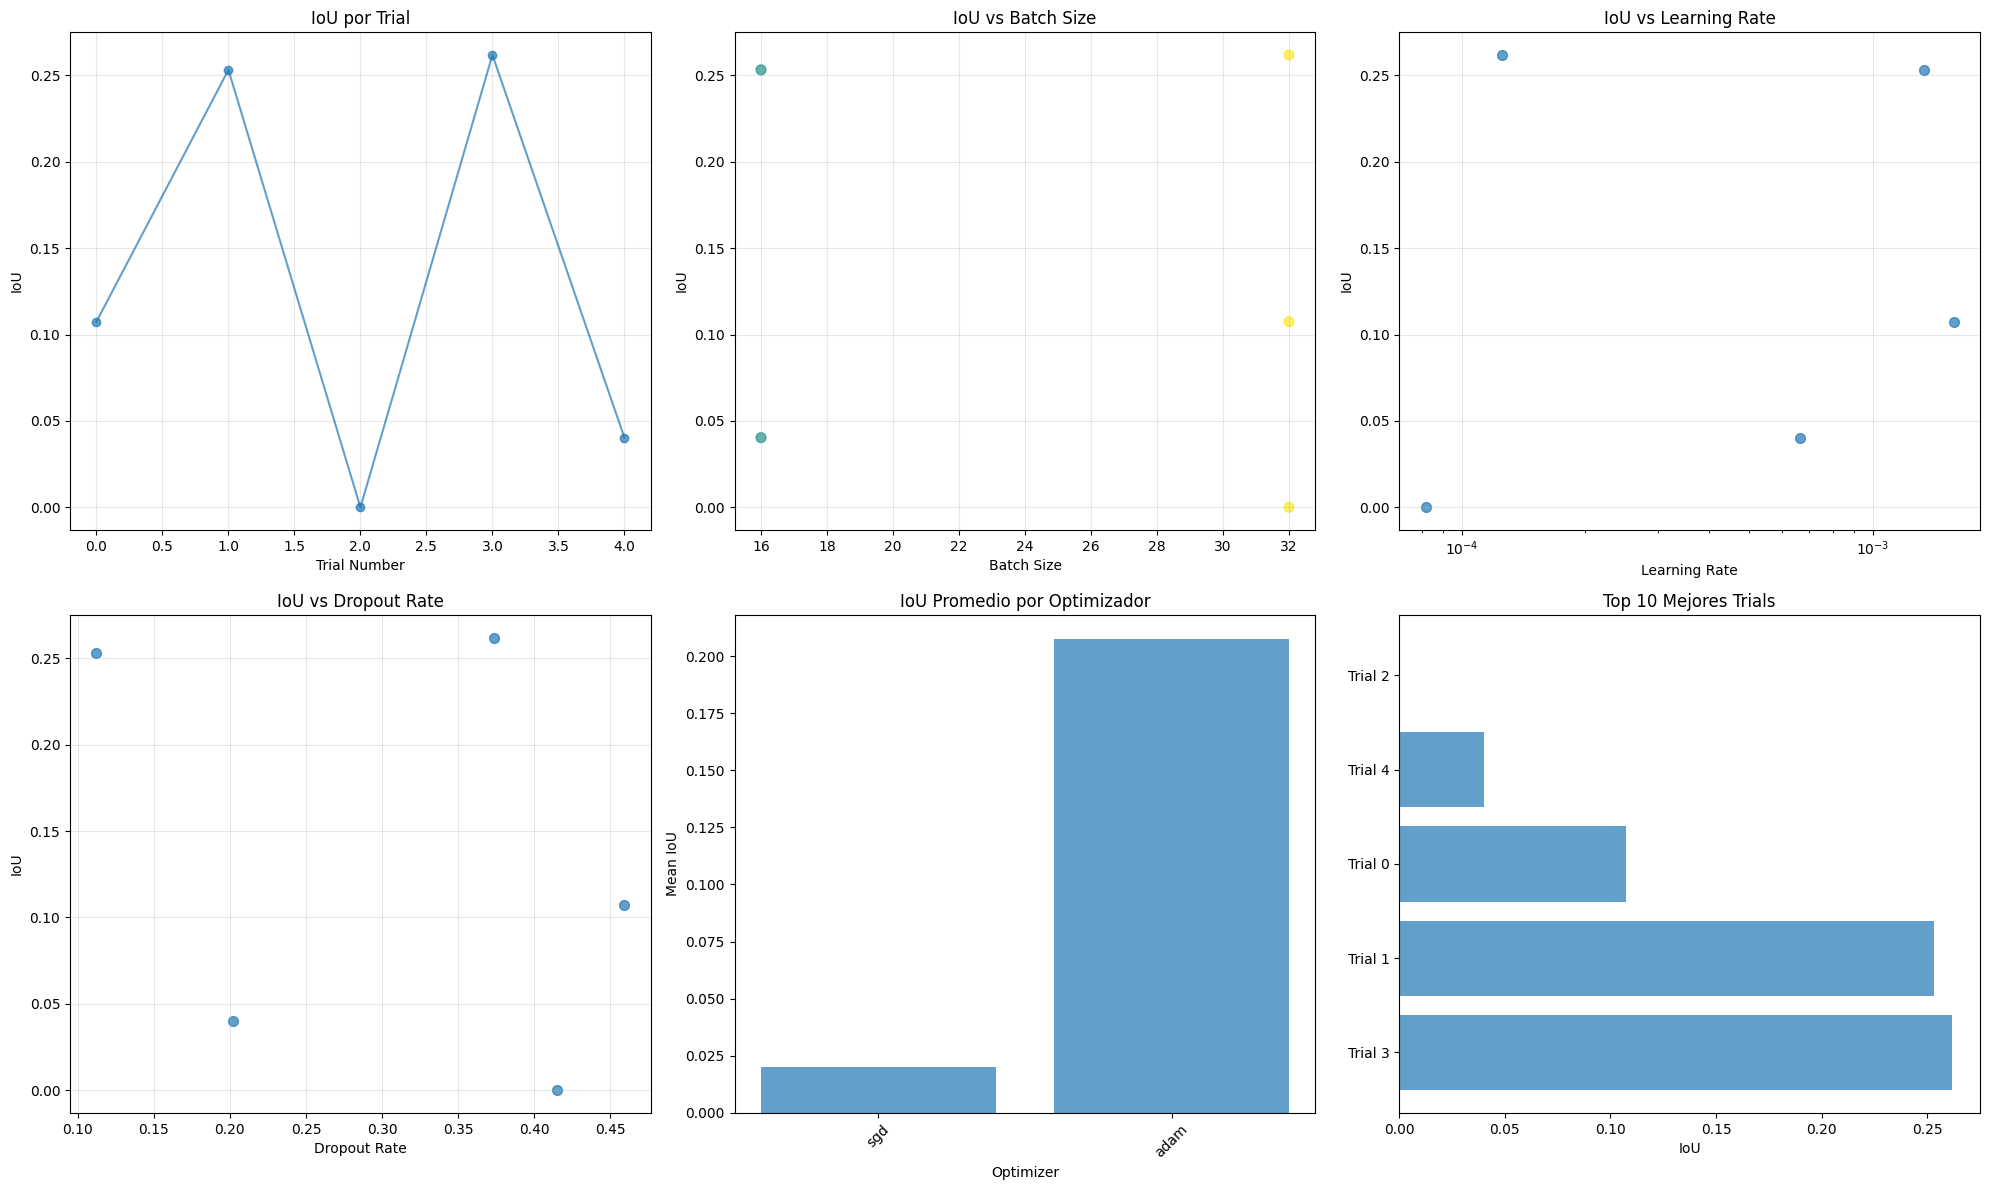


📋 TOP 5 MEJORES TRIALS:
--------------------------------------------------------------------------------

1. Trial #3 - IoU: 0.2619
   Batch Size: 32
   Learning Rate: 0.000126
   Dropout Rate: 0.374
   Optimizer: adam

2. Trial #1 - IoU: 0.2532
   Batch Size: 16
   Learning Rate: 0.001331
   Dropout Rate: 0.112
   Optimizer: adam

3. Trial #0 - IoU: 0.1074
   Batch Size: 32
   Learning Rate: 0.001570
   Dropout Rate: 0.459
   Optimizer: adam

4. Trial #4 - IoU: 0.0403
   Batch Size: 16
   Learning Rate: 0.000665
   Dropout Rate: 0.202
   Optimizer: sgd

5. Trial #2 - IoU: 0.0000
   Batch Size: 32
   Learning Rate: 0.000082
   Dropout Rate: 0.415
   Optimizer: sgd
⚠️ Pocos trials completados para análisis de correlación
✅ Visualizaciones completadas

🏆 FASE 4: ENTRENAMIENTO CON MEJORES HIPERPARÁMETROS
----------------------------------------
🏆 ENTRENANDO MODELO CON MEJORES HIPERPARÁMETROS
Mejor IoU encontrado: 0.2619
Mejores parámetros:
  batch_size: 32
  learning_rate: 0.000125627735

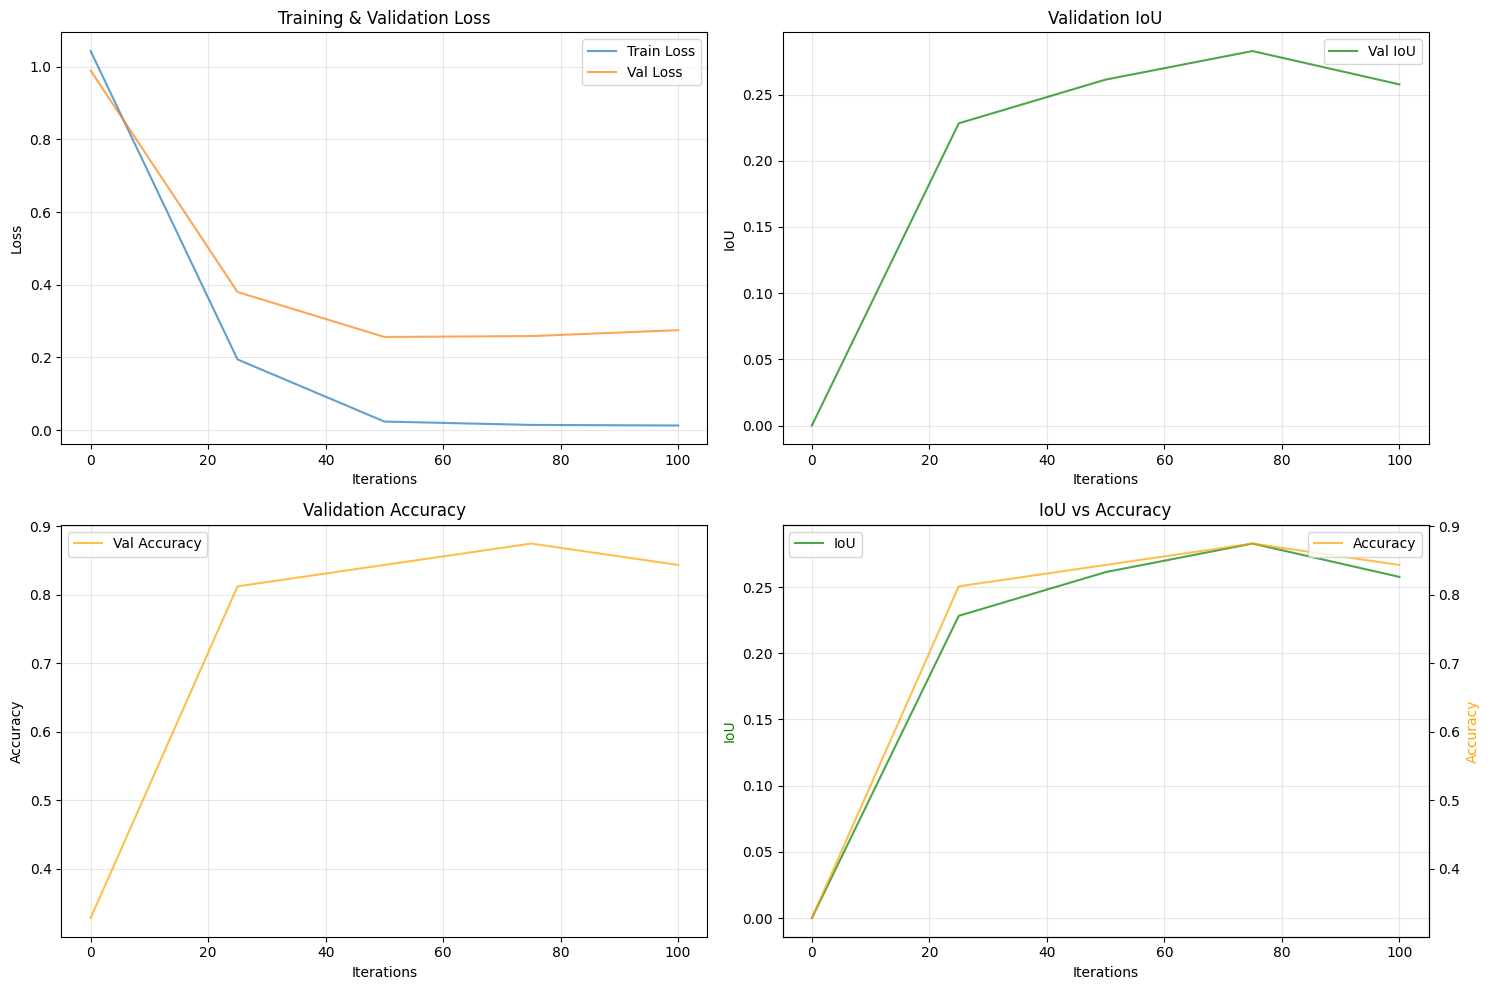


📈 ESTADÍSTICAS FINALES:
   Mejor IoU: 0.2829
   Mejor Accuracy: 0.8750
   Menor Val Loss: 0.2564
✅ Mejor modelo entrenado

💾 FASE 5: EVALUACIÓN Y GUARDADO
----------------------------------------
📊 EVALUANDO MODELO EN VALIDACIÓN
🔄 Evaluando...


Evaluando: 100%|██████████| 3/3 [00:06<00:00,  2.25s/it]



🎯 RESULTADOS DE EVALUACIÓN:
  IoU promedio: 0.2720
  Accuracy promedio: 0.8750
  Loss promedio: 0.2604

📊 Accuracy por clase:
  f16: 1.0000
  cougar: 0.8889
  chinook: 1.0000
  ah64: 0.8889
  f15: 0.6667
  seahawk: 0.6000
💾 Modelo guardado en: ./Resultados/optuna_best_model_20250525_20_56.pth
💾 Parámetros guardados en: ./Resultados/optuna_best_params_20250525_20_56.json
💾 Historial guardado en: ./Resultados/optuna_training_history_20250525_20_56.json
✅ Modelo guardado exitosamente

🎯 FASE 6: GENERACIÓN DE PREDICCIONES
----------------------------------------
🎯 GENERANDO PREDICCIONES CON MODELO OPTIMIZADO
📊 Procesando 63 imágenes de test...
🔄 Realizando predicciones...


Prediciendo: 100%|██████████| 63/63 [00:04<00:00, 13.70it/s]

✅ Predicciones completadas: 63 imágenes
💾 Submission guardado en: ./Resultados/optuna_submission_20250525_20_01.csv

📊 ESTADÍSTICAS DE PREDICCIONES:
  Distribución de clases:
    f16: 16 (25.4%)
    ah64: 15 (23.8%)
    chinook: 11 (17.5%)
    cougar: 10 (15.9%)
    seahawk: 6 (9.5%)
    f15: 5 (7.9%)
  Estadísticas de bounding boxes:
         xmin    ymin     xmax    ymax
count   63.00   63.00    63.00   63.00
mean   340.20  205.68   838.16  408.19
std    150.43   74.08   181.66  101.47
min     11.61   41.06   400.43  217.56
25%    240.40  157.93   726.64  340.94
50%    314.89  208.76   830.57  385.27
75%    457.77  235.98   957.36  488.38
max    737.57  409.14  1251.36  633.84
✅ Submission generado

🎉 OPTIMIZACIÓN COMPLETADA EXITOSAMENTE
📊 RESUMEN DE RESULTADOS:
   Total trials ejecutados: 5
   Mejor IoU (optimización): 0.2619
   IoU en validación final: 0.2720
   Accuracy en validación: 0.8750

🏆 MEJORES HIPERPARÁMETROS:
   batch_size: 32
   learning_rate: 0.00012562773503807024
   

{'study': <optuna.study.study.Study at 0x1d19ad481a0>,
 'best_model': OptimizableModel(
   (backbone): ConfigurableFeatureExtractor(
     (features): Sequential(
       (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
       (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu0): ReLU(inplace=True)
       (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
       (denseblock1): _DenseBlock(
         (denselayer1): _DenseLayer(
           (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (relu1): ReLU(inplace=True)
           (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
           (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
           (relu2): ReLU(inplace=True)
           (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [43]:
quick_optimization_example()

In [44]:
#run_complete_optimization_example()